In [1]:
import pandas as pd
from datetime import datetime
import pm4py
import numpy as np
from collections import defaultdict
from Levenshtein import distance

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

import copy

In [2]:
log1 = pm4py.read.read_xes("BPI_Challenge_2019_DF1.xes")

C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 5292/5292 [00:19<00:00, 275.54it/s]


In [3]:
log2 = pm4py.read.read_xes("BPI_Challenge_2019_DF2.xes")

parsing log, completed traces :: 100%|██████████| 16097/16097 [00:15<00:00, 1055.91it/s]


In [4]:
log3 = pm4py.read.read_xes("BPI_Challenge_2019_DF3.xes")

parsing log, completed traces :: 100%|██████████| 196/196 [00:00<00:00, 792.10it/s]


In [5]:
log4 = pm4py.read.read_xes("BPI_Challenge_2019_DF4.xes")

parsing log, completed traces :: 100%|██████████| 54/54 [00:00<00:00, 863.80it/s]


In [6]:
# Initialize LabelEncoder
le = LabelEncoder()

In [7]:
log1['type'] = 'DF1'
log1['case:concept:name'] = 'DF1' + log1['case:concept:name']

log2['type'] = 'DF2' 
log2['case:concept:name'] = 'DF2' + log2['case:concept:name']

log3['type'] = 'DF3' 
log3['case:concept:name'] = 'DF3' + log3['case:concept:name']

log4['type'] = 'DF4' 
log4['case:concept:name'] = 'DF4' + log4['case:concept:name']

In [8]:
log1.nunique()

lifecycle:transition                  1
time:timestamp                    36867
concept:name                         36
org:resource                        208
User                                208
Cumulative net worth (EUR)        17309
case:concept:name                  5292
case:variant                       3913
case:variant-index                 3913
case:creator                          1
case:Spend area text                 18
case:Company                          1
case:Document Type                    3
case:Sub spend area text             68
case:Purchasing Document           4816
case:Purch. Doc. Category name        1
case:Vendor                         404
case:Item Type                        4
case:Item Category                    1
case:Spend classification text        3
case:Source                           1
case:Name                           400
case:GR-Based Inv. Verif.             1
case:Item                            69
case:Goods Receipt                    1


In [9]:
log = pd.concat([log1, log2, log3, log4]).reset_index()

In [10]:
# Fit and transform the 'tabName_element' column
log['activity'] = le.fit_transform(log['concept:name'])

In [11]:
#Create trace log
logVar0 = log.groupby(['case:concept:name'])['activity'].apply(list).reset_index()

In [12]:
logType = log.groupby(['case:concept:name'])['type'].apply(list).reset_index()
logType['type'] = logType['type'].apply(lambda x: set(x))
logType['type'] = logType['type'].apply(lambda x: ''.join(x))

In [13]:
logVar0 = pd.merge(logVar0, logType, on='case:concept:name')

In [14]:
logVar0

,case:concept:name,activity,type
0,DF12000000001_00001,"[29, 28, 26, 31, 35, 33, 27, 14, 41, 19, 21, 2...",DF1
1,DF12000000002_00001,"[29, 28, 26, 31, 35, 33, 27, 14, 19, 21, 41, 1...",DF1
2,DF12000000005_00002,"[29, 28, 26, 31, 33, 35, 14, 27]",DF1
3,DF12000000006_00001,"[29, 28, 26, 31, 33, 35, 27, 14, 41, 19, 21, 2...",DF1
4,DF12000000008_00001,"[29, 28, 26, 31, 33, 35, 27, 14, 41, 19, 21, 2...",DF1
...,...,...,...
21634,DF44508060051_00020,"[15, 14, 19, 19, 19, 19, 9, 19]",DF4
21635,DF44508068545_00010,"[15, 14, 9, 9, 18, 9, 9, 19]",DF4
21636,DF44508069068_00010,"[15, 14, 9, 9, 18, 9, 19, 6]",DF4
21637,DF44508073350_00030,"[15, 14, 9, 19, 19, 19, 19, 19, 19, 19]",DF4


In [15]:
logVar0["c:n_chr"] = logVar0["activity"].apply(lambda x: [chr(int(i)) for i in x])
logVar0["strings"] = logVar0["c:n_chr"].apply(lambda x: ''.join(x))
logVar0

,case:concept:name,activity,type,c:n_chr,strings
0,DF12000000001_00001,"[29, 28, 26, 31, 35, 33, 27, 14, 41, 19, 21, 2...",DF1,"[ , , , , #, !, , , ), , , , \r, !, %]", #!)\r!%
1,DF12000000002_00001,"[29, 28, 26, 31, 35, 33, 27, 14, 19, 21, 41, 1...",DF1,"[ , , , , #, !, , , , , ), , , , , ...", #!)\r!%
2,DF12000000005_00002,"[29, 28, 26, 31, 33, 35, 14, 27]",DF1,"[ , , , , !, #, , ]", !#
3,DF12000000006_00001,"[29, 28, 26, 31, 33, 35, 27, 14, 41, 19, 21, 2...",DF1,"[ , , , , !, #, , , ), , , , \r, !, ]", !#)\r!
4,DF12000000008_00001,"[29, 28, 26, 31, 33, 35, 27, 14, 41, 19, 21, 2...",DF1,"[ , , , , !, #, , , ), , , , \r]", !#)\r
...,...,...,...,...,...
21634,DF44508060051_00020,"[15, 14, 19, 19, 19, 19, 9, 19]",DF4,"[, , , , , , \t, ]",\t
21635,DF44508068545_00010,"[15, 14, 9, 9, 18, 9, 9, 19]",DF4,"[, , \t, \t, , \t, \t, ]",\t\t\t\t
21636,DF44508069068_00010,"[15, 14, 9, 9, 18, 9, 19, 6]",DF4,"[, , \t, \t, , \t, , ]",\t\t\t
21637,DF44508073350_00030,"[15, 14, 9, 19, 19, 19, 19, 19, 19, 19]",DF4,"[, , \t, , , , , , , ]",\t


In [16]:
#Derive set set of trace variants

logVar = logVar0.drop_duplicates(subset=['strings'], keep='first')
logVar = logVar.reset_index(drop=True)
logVar

,case:concept:name,activity,type,c:n_chr,strings
0,DF12000000001_00001,"[29, 28, 26, 31, 35, 33, 27, 14, 41, 19, 21, 2...",DF1,"[ , , , , #, !, , , ), , , , \r, !, %]", #!)\r!%
1,DF12000000002_00001,"[29, 28, 26, 31, 35, 33, 27, 14, 19, 21, 41, 1...",DF1,"[ , , , , #, !, , , , , ), , , , , ...", #!)\r!%
2,DF12000000005_00002,"[29, 28, 26, 31, 33, 35, 14, 27]",DF1,"[ , , , , !, #, , ]", !#
3,DF12000000006_00001,"[29, 28, 26, 31, 33, 35, 27, 14, 41, 19, 21, 2...",DF1,"[ , , , , !, #, , , ), , , , \r, !, ]", !#)\r!
4,DF12000000008_00001,"[29, 28, 26, 31, 33, 35, 27, 14, 41, 19, 21, 2...",DF1,"[ , , , , !, #, , , ), , , , \r]", !#)\r
...,...,...,...,...,...
10202,DF34508076162_00010,"[41, 40, 14, 4, 4, 8, 4, 20, 2, 13, 20, 13]",DF3,"[), (, , , , , , , , \r, , \r]",)(\r\r
10203,DF34508076169_00020,"[41, 4, 4, 14, 4, 20, 13, 4, 4]",DF3,"[), , , , , , \r, , ]",)\r
10204,DF34508076206_00050,"[41, 4, 4, 4, 4, 14, 4, 20]",DF3,"[), , , , , , , ]",)
10205,DF34508076207_00020,"[4, 4, 14, 4, 20, 41, 4, 4]",DF3,"[, , , , , ), , ]",)


In [17]:
# Number of activity types
act = list(set([a for b in logVar.activity.tolist() for a in b]))
len(act)

42

In [18]:
#min, max length of traces
logVar["length"] = logVar["activity"].apply(lambda x: len(x))
print(logVar.length.min(), logVar.length.max())

8 990


## Derive Variety Values

In [28]:
#Select random subsets of trace variants
#logVar1 = logVar.sample(n=1000, random_state=10)
#logVar1 = logVar1.reset_index(drop=True)
#logVar1

In [19]:
#Calculate linkage Matrix
from scipy.cluster.hierarchy import linkage

#Distances after clustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import squareform

#For Evaluation
from scipy.integrate import simpson
from numpy import trapz
import scipy.stats
from scipy.cluster.hierarchy import fcluster

In [20]:
#Calculate overall Variety based on Minimum Spanning Tree
def mst(linkage_matrix):
    x = 0
    for i in linkage_matrix:
        x += i[2]
    return x

#logVariety = mst(linkage_matrix)
#logVariety

In [21]:
#Derive ordering of traces based on their marginal distance

def marginal_variety(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(len(pairwise_distances)-1):
        # Find the minimum value and its indices
        min_val = np.nanmin(modified_distances)  # Use np.nanmin to ignore NaN values
        min_indices = np.argwhere(modified_distances == min_val)
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = min_indices[0][0], min_indices[0][0]
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)
        margVariety.append(min_val)
        
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
    #return modified_distances
    return traceOrder, margVariety #modified_distances


#order, margVar = marginal_variety(cophenet_matrix)
#margVar

In [22]:
def alignMatrix(list_of_strings):
    n = len(list_of_strings)
    dist_matrix = np.zeros((n,n))    # initialize distance matrix to a square of zeros

    for i in range(n):
        if i % 20 == 0:
            print(i)
        for j in range(i, n):
            dist_matrix[i,j] = nw(list_of_strings[i], list_of_strings[j])
            dist_matrix[j,i] = dist_matrix[i,j]       # for the symmetric part, no computation
            
    return dist_matrix


#listVec = logVar["strings"]
#Matrix_Align = alignMatrix(listVec)
#Matrix_Align

In [23]:
#Create ordered list of Alignment costs

def marginal_alignments(pairwise_distances, order):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    modified_distances = abs(modified_distances)
    #traceOrder = []
    margAlignments = []
    
    removed = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate over ordered list of trace variants to be removed
    for i in order:
        #Add i to list of removed TraceVar
        removed.append(i)
        alignmentCost = 0
        
        #Change values in the column corresponding to i to NaN
        modified_distances[:, i] = np.nan
        
        #Iterate over list of removed trace variants to derive alignment costs
        for i in removed:
            
            # Find the minimum value and its indices
            min_val = np.nanmin(modified_distances[i])  # Use np.nanmin to ignore NaN values
            
            #Add value to alignment cost
            alignmentCost += min_val
 
        #Add alignment cost to list
        margAlignments.append(alignmentCost)
        
        
    #return modified_distances
    return margAlignments #modified_distances



#margAlignCosts = marginal_alignments(Matrix_Align, order)
#margAlignCosts

In [24]:
#Calculate increase in alignment costs
def alignIncrease(margAlignCosts):
    inAlign = [0]
    newAlign = 0
    for i in margAlignCosts:
        newAlign += i
        inAlign.append(newAlign)
    return inAlign

#alignCostIncrease = alignIncrease(margAlignCosts)

In [25]:
#Calculate decrease in variety
def varDecrease(var, margVar):
    deVar = [var]
    newVar = var
    for i in margVar:
        newVar -= i
        deVar.append(newVar)
    return deVar

#varietyDecrease = varDecrease(logVariety, margVar)

## Based on Levenshtein Distance

In [26]:
#Calculate distance matrix based on Levenshtein Distance
from Levenshtein import distance

def Lev(logVar):
    
    List = logVar["strings"]

    n = len(List)
    dist_matrix = np.zeros((n,n))    # initialize distance matrix to a square of zeros

    for i in range(n):
        if i % 200 == 0:
            print(i)
        for j in range(i, n):
            dist_matrix[i,j] = distance(List[i], List[j])
            dist_matrix[j,i] = dist_matrix[i,j]       # for the symmetric part, no computation

    return dist_matrix

In [27]:
lev_dis = Lev(logVar)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200


In [42]:
from scipy.cluster.hierarchy import fcluster

def varAlignCosts(Matrix_Align):
    
    #Calculate linkage Matrix
    linkage_matrix = linkage(Matrix_Align, "complete")
    #linkage_matrix

    #Calculate overall Variety based on Minimum Spanning Tree
    logVariety = mst(linkage_matrix)
    print('Overall variety:', logVariety)

    #Distances after clustering
    cophenet_matrix = squareform(cophenet(linkage_matrix))

    #Derive ordering of traces based on their marginal distance
    order, margVar = marginal_variety(cophenet_matrix)
    print('Order:', order)

    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    print('margAlignCosts')

    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)
        
    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(cophenet_matrix)))
    y = varietyDecrease
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)


    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    

    #Evaluate Clustering
    labels = fcluster(linkage_matrix, t=len(logVar)/2, criterion='maxclust')
    silhoutte = metrics.silhouette_score(abs(Matrix_Align), labels, metric="precomputed")
    print("silhouette_value", silhoutte)

C:\Users\la1949\AppData\Local\Temp\ipykernel_5476\1907571381.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(Matrix_Align, "complete")


Overall variety: 1681291.8542796986
Order: [5880, 10159, 5879, 4742, 9126, 4690, 4123, 5593, 249, 68, 4707, 225, 61, 0, 3, 82, 123, 5883, 6516, 10143, 10109, 5212, 86, 1943, 203, 244, 1981, 1840, 3944, 214, 10118, 4296, 7933, 3981, 2, 143, 7210, 3648, 1820, 4710, 4922, 1261, 3964, 1813, 1501, 6005, 5151, 241, 3223, 1646, 2570, 1787, 8754, 33, 98, 5390, 1169, 2535, 4853, 187, 3991, 4991, 71, 4964, 4990, 1387, 809, 205, 274, 3941, 215, 73, 2042, 2728, 150, 23, 3947, 3942, 885, 5475, 8, 1227, 77, 271, 759, 529, 5928, 3580, 1565, 263, 5007, 182, 4498, 2051, 1713, 3921, 3922, 4907, 155, 622, 1279, 1633, 2282, 50, 1574, 240, 1875, 405, 4846, 37, 4656, 4839, 761, 1490, 4586, 8925, 4852, 6767, 255, 8065, 201, 4605, 32, 4838, 29, 4001, 1512, 2664, 5310, 494, 3999, 4039, 4418, 1553, 854, 4444, 101, 3960, 9242, 8011, 4183, 1632, 3513, 5177, 4042, 7735, 871, 2499, 4548, 1800, 6429, 1484, 3995, 5875, 8972, 6337, 6580, 8255, 6241, 4855, 525, 855, 1288, 6934, 1445, 702, 4693, 5343, 4731, 777, 6881, 6

margAlignCosts


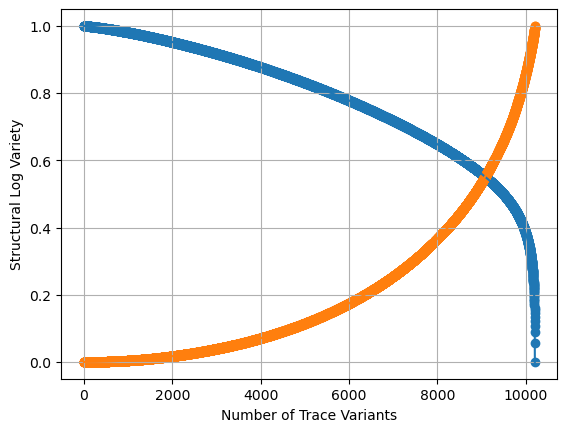

intersection: [9078]
area_trapeziodal: 2151.6278081877153
area_Simpson: 2151.6276904663778
Pearson's r: PearsonRResult(statistic=-0.981998930810132, pvalue=0.0)
silhouette_value -0.026543106886716517


In [43]:
varAlignCosts(lev_dis)

## Baseline

In [28]:
#Derive ordering of traces based on random selection
import math

def marginal_variety_baseline(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    totalVariety = []
    numbVar = len(pairwise_distances)
    remaining = list(range(0,numbVar))
    
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(numbVar-1):
        
        #Select random variant to be removed
        indices = np.random.choice(remaining)
        remaining.remove(indices)
        min_val = np.nanmin(modified_distances[indices])
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = indices, indices
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)        
        margVariety.append(min_val)
        
        #Calculate variety based on distances of remaining traces 
        variety = 0
        for i in modified_distances:
            if math.isnan(np.nanmin(i)):
                continue
            variety += np.nanmin(i)
        totalVariety.append(variety)
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
        
    #return modified_distances
    return traceOrder, margVariety, totalVariety #modified_distances

In [29]:
def varAlignCosts2(Matrix_Align):

    #Derive ordering of traces based on their marginal distance
    #order, margVar = marginal_variety(cophenet_matrix)
    order, margVar, totalVar = marginal_variety_baseline(Matrix_Align)
    totalVar.append(0)
    
    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    
    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)
    
    
    #Calculate overall Variety based on sum of margVar
    logVariety = sum(margVar)
    print('Overall variety:', logVariety)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)


    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(Matrix_Align)))
    y = totalVar
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)

    # Achsen-Bereiche manuell festlegen
    # Syntax: plt.axis([xmin, xmax, ymin, ymax])
    #plt.axis([0, 5, 0, 20])

    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    #from scipy.integrate import simpson
    #from numpy import trapz
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)

    #Monotonicity trend
    diffs = np.diff(totalVar)
    monoRate = np.sum(diffs >= 0) / (len(totalVar)-2)
    print("monotonViolation:", monoRate)
    print("equality:", np.sum(diffs == 0))
    print("increase:", np.sum(diffs > 0))

    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 

C:\Users\la1949\AppData\Local\Temp\ipykernel_8952\3781539750.py:36: RuntimeWarning: All-NaN slice encountered
  if math.isnan(np.nanmin(i)):


Overall variety: 60342.0


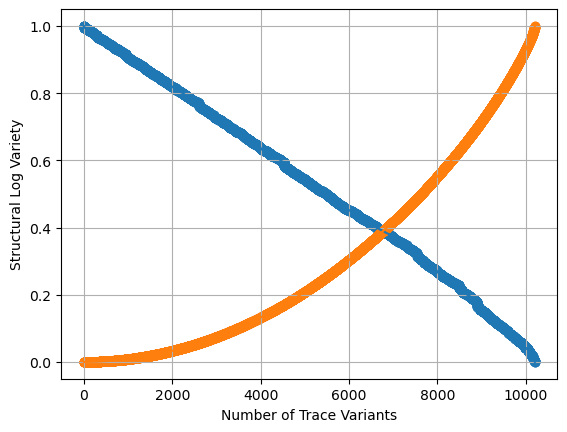

intersection: [6769]
area_trapeziodal: 3087.0593977867784
area_Simpson: 3087.0593026963907
monotonViolation: 0.1749142577168055
equality: 1207
increase: 578
Pearson's r: PearsonRResult(statistic=-0.9674819164469183, pvalue=0.0)
Spearman's rho: SignificanceResult(statistic=-0.999999931093294, pvalue=0.0)
Kendall's tau: SignificanceResult(statistic=-0.9999240767383524, pvalue=0.0)


In [30]:
varAlignCosts2(lev_dis)